In [14]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score


<Figure size 864x504 with 0 Axes>

In [35]:
# set models and labels
time_points = ['1_year', '3_year', '5_year']
models = ['catboost', 'resnet']
iteration_num = 1000 # iteration times

auc_dict = {
    'model': [],
    'timestamp': [],
    'auroc': [],
    'random_seed': []
}

for model in models:
    for time_point in time_points:
        auc_list = []
        random_list = []
        with tqdm(total=iteration_num) as pbar:
            result_df = pd.read_csv("/data/padmalab/echo/data/processed/AUROC/"+time_point+"_mortality_probability_"+model+".csv")
            for i in range(iteration_num):
                '''
                Key for boostrap, sample for N times with replacement
                '''
                sample_df = result_df.sample(n=result_df.shape[0], replace=True, random_state=i)
                auc = roc_auc_score(sample_df['ground_truth'].tolist(), sample_df['class_1_prob'].tolist())
                auc_list.append(auc)
                random_list.append(i)
                pbar.update(1)
            
        auc_dict['model'].extend([model]*iteration_num)
        auc_dict['timestamp'].extend([time_point]*iteration_num)
        auc_dict['auroc'].extend(auc_list)
        auc_dict['random_seed'].extend(random_list)
        
        # create the dataframe

df = pd.DataFrame.from_dict(auc_dict)
print (df.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 589.55it/s]


(60000, 4)


Draw the plots

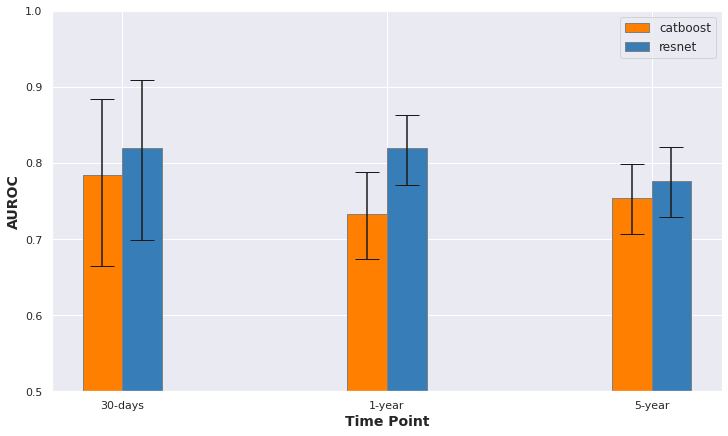

In [36]:

sns.set_theme(style="darkgrid")

plt.figure(figsize=(12,7))

colors = ['#ff7f00','#377eb8', '#e41a1c',  '#984ea3', '#4daf4a']

barWidth = 0.15
br1 = np.arange(len(time_points))
br_list = [br1]
for i in range(len(models)):
    br1 = br_list[-1]
    br_list.append([x + barWidth for x in br1])

for index in range(len(models)):
    model = models[index]
    means = []
    ci_lists = []
    for time_point in time_points:
        auc = df[(df['model'] == model) & (df['timestamp'] == time_point)]['auroc'].to_list()
        means.append(np.mean(auc))
        '''
        Calculate 2.5 - 97.5 quartile as error bar
        '''
        lower_quartile = np.mean(auc) - np.percentile(auc, 2.5, axis=0)
        upper_quartile = np.percentile(auc, 97.5, axis=0) - np.mean(auc)
        
        ci_lists.append([lower_quartile,upper_quartile])
    plt.bar(br_list[index], means, yerr=np.array(ci_lists).T, color = colors[index], width = barWidth, 
            edgecolor ='grey', label =model, capsize=12)

plt.xlabel('Time Point', fontweight ='bold', fontsize = 14)
plt.ylabel('AUROC', fontweight ='bold', fontsize = 14)
plt.xticks([r + .5* barWidth for r in range(3)],
        ['1-year', '3-years', '5-years'])
plt.ylim(0.50, 1)
plt.legend(fontsize = 12)
plt.show()